# Visualization: Static ILP Autoscaler Demo

This notebook visualizes the inputs and outputs of the ILP solver. It loads the data structures, generates mock data, runs the solver, and then creates plots for:

1.  **Performance Profile:** Shows the maximum throughput of different worker units for various request types.
2.  **Request Rate Distribution:** A 3D histogram showing the incoming request rate for different request sizes and SLOs.
3.  **ILP Solution:** The calculated optimal number of worker units to provision and the associated cost.

Ensure the required Python files (`data_structures.py`, `mock_generators.py`, `ilp_solver.py`) are in the same directory as this notebook, and necessary libraries are installed in your remote Python environment (`pip install ortools pandas matplotlib seaborn plotly nbformat`).

In [ ]:
# Cell 0: Imports and Setup

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Any
from colabtools import adhoc_import
adhoc_import.InitializeFromSrcfs() # Plotly uses dynamic imports
import plotly.express as px
import plotly.graph_objects as go
import numpy as np # For 3D plotting positions


# Import project modules (assuming they are in the same directory)
try:
    from data_structures import WorkerUnit, RequestType
    from mock_generators import generate_mock_profile, generate_mock_distribution, MOCK_GENERATOR_CONFIG
    from ilp_solver import solve_provisioning_ilp
    print("Project modules imported successfully.")
except ImportError as e:
    print(f"Error importing project modules: {e}")
    print("Please ensure .py files are in the same directory or accessible.")
    exit()


# Configure plotting style (optional)
sns.set_theme(style="whitegrid")
print("Setup complete.")

Project modules imported successfully.
Setup complete.


## 1. Generate Mock Data and Run Solver

First, we define the mock worker units and request types, then generate the performance profile and request distribution using the mock generators. Finally, we run the ILP solver to get the optimal provisioning plan based on this static data.

In [ ]:
# Cell 1: Load/Generate Data & Run Solver


print("--- Defining Infrastructure & Request Types (Input/Output Split) ---")

# --- Define Mock Worker Units ---
worker_units = [
    WorkerUnit(id='L4x1_TGI', accelerator_type='L4', accelerator_count=1, model_server_type='TGI', cost=0.71),
    WorkerUnit(id='L4x2_TGI', accelerator_type='L4', accelerator_count=2, model_server_type='TGI', cost=1.3),
    WorkerUnit(id='A10Gx1_TGI', accelerator_type='A10G', accelerator_count=1, model_server_type='TGI', cost=1.62),
    WorkerUnit(id='A10Gx2_TGI', accelerator_type='A10G', accelerator_count=2, model_server_type='TGI', cost=3.24),
    WorkerUnit(id='A100x1_VLLM', accelerator_type='A100', accelerator_count=1, model_server_type='VLLM', cost=3.67),
    WorkerUnit(id='A100x2_VLLM', accelerator_type='A100', accelerator_count=2, model_server_type='VLLM', cost=7.35),
    WorkerUnit(id='H100x1_VLLM', accelerator_type='H100', accelerator_count=1, model_server_type='VLLM', cost=11.06),
    WorkerUnit(id='H100x2_VLLM', accelerator_type='H100', accelerator_count=2, model_server_type='VLLM', cost=22.0),
    WorkerUnit(id='TPUv5e-4_SAX', accelerator_type='TPU-V5e', accelerator_count=4, model_server_type='SAX', cost=4.8, max_limit=1), # seems unrealisticly efficient given the cost
]
worker_unit_map = {w.id: w for w in worker_units}

# --- Define Request Types (5x5x5 = 125 types) ---
print("Generating full set of potential request types...")
INPUT_SIZES = ['XS', 'S', 'M', 'L', 'XL']
OUTPUT_SIZES = ['XS', 'S', 'M', 'L', 'XL']
SLO_LEVELS_MS = [200, 500, 1000, 2000, 4000]

request_types: List[RequestType] = []
for in_size in INPUT_SIZES:
    for out_size in OUTPUT_SIZES:
        for slo_ms in SLO_LEVELS_MS:
            req_id = f"in{in_size}_out{out_size}_slo{slo_ms}"
            request_types.append(RequestType(
                id=req_id,
                input_size_bucket=in_size,
                output_size_bucket=out_size,
                slo_ms=slo_ms
            ))

request_type_map = {rt.id: rt for rt in request_types}
print(f"Defined {len(worker_units)} worker units and {len(request_types)} potential request types.")

# --- Create Position Maps with Correct Sorting (also used in later cells) ---
print("Creating position maps for visualizations...")
input_size_map_viz: Dict[str, int] = {}
output_size_map_viz: Dict[str, int] = {}
slo_map_viz: Dict[int, int] = {}
if request_types:
    # Use sets for efficiency
    unique_input_sizes = set(rt.input_size_bucket for rt in request_types)
    unique_output_sizes = set(rt.output_size_bucket for rt in request_types)
    unique_slos = set(rt.slo_ms for rt in request_types)

    # Define custom sort order for sizes
    size_order = ['XS', 'S', 'M', 'L', 'XL']
    # Sort unique sizes based on the predefined order
    input_size_categories_viz = sorted(
        unique_input_sizes, key=lambda x: size_order.index(x) if x in size_order else float('inf')
    )
    output_size_categories_viz = sorted(
        unique_output_sizes, key=lambda x: size_order.index(x) if x in size_order else float('inf')
    )
    input_size_map_viz = {cat: i for i, cat in enumerate(input_size_categories_viz)}
    output_size_map_viz = {cat: i for i, cat in enumerate(output_size_categories_viz)}

    # Sort SLOs numerically
    slo_categories_viz = sorted(list(unique_slos))
    slo_map_viz = {cat: i for i, cat in enumerate(slo_categories_viz)}
    print("...Position maps created with custom size sort.")
else:
    print("Warning: No request types defined, cannot create position maps.")


print("\n--- Generating Mock Data ---")
# Profile is generated for ALL 125 potential request types
profile_data = generate_mock_profile(worker_units, request_types, config=MOCK_GENERATOR_CONFIG)

# Distribution assigns rates only to a SUBSET (e.g., ~60) of types
# Use max_active_request_types from config
max_active_types = MOCK_GENERATOR_CONFIG.get("max_active_request_types", 60)
distribution_data = generate_mock_distribution(
    request_types=request_types, # Pass all types
    total_rate=75.0, # Your updated rate
    # --- Optional Biases ---
    # size_bias='L',
    # slo_bias='low',
    # --- Limit Active Types ---
    config={**MOCK_GENERATOR_CONFIG, "max_active_request_types": max_active_types} # Pass limit via config
)


print("\n--- Running ILP Solver ---")
# Solver only sees request types present in distribution_data
optimal_counts, slice_assignments, slices = solve_provisioning_ilp(
    worker_units=worker_units,
    profile_data=profile_data,
    distribution_data=distribution_data, # Sparse distribution
    slice_factor=3 # Example value
)
print("\nOptimal Counts:", optimal_counts if optimal_counts else "Solver Failed")


# Store results for later visualization
if optimal_counts is None:
    print("Solver did not find an optimal solution. Cannot proceed.")
    optimal_counts = {}
    slice_assignments = {}
    # slices list still returned by solver

print("\n--- Data Generation and Solver Execution Complete ---")

--- Defining Infrastructure & Request Types (Input/Output Split) ---
Generating full set of potential request types...
Defined 9 worker units and 125 potential request types.
Creating position maps for visualizations...
...Position maps created with custom size sort.

--- Generating Mock Data ---
Generating Mock Profile Data (RPS) for 125 potential request types...
...Mock Profile Generation Complete.
Generating Mock Distribution Data (Total Rate: 75.0 RPS, Target Active Types: 60, Size Bias: None, SLO Bias: None)...
  Selected 60 types to assign rates to.
  (Actual total rate generated across 60 active types: 75.00 req/s)
...Mock Distribution Generation Complete.

--- Running ILP Solver ---

--- Starting ILP Solver (with Max Limit Constraint) ---
Creating slices (slice_factor=3)...
...Created 180 slices.
Calculating load matrix L_ij...
...Load matrix calculated.
Using solver: SCIP 7.0.1 [LP solver: SoPlex 6.0.4]
Declaring ILP variables...
Defining constraints...
  Constraint 3: Worker

## 2. Visualize Performance Profile

This heatmap shows the mock maximum throughput (requests/second) for each combination of Worker Unit (MSRS) and Request Type. Higher values indicate better performance for that specific combination under the request's implicit SLO.

--- Generating Performance Profile Heatmap ---
Generating Heatmap...


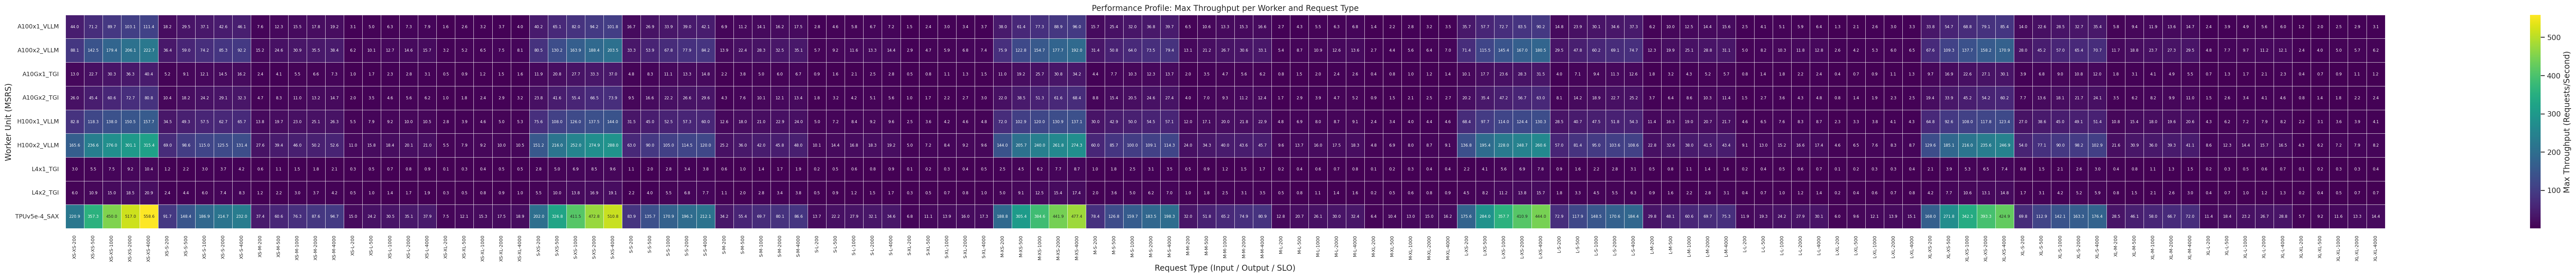

In [ ]:
# Cell 2: Visualize Performance Profile

print("--- Generating Performance Profile Heatmap ---")

# --- Check if prerequisite data from Cell 4 exists ---
# Needs: profile_data, request_type_map, worker_unit_map
# AND the correctly named sorted category lists from Cell 4
if ('profile_data' in locals() and profile_data and
    'request_type_map' in locals() and request_type_map and
    'worker_unit_map' in locals() and worker_unit_map and
    'input_size_categories_viz' in locals() and input_size_categories_viz and
    'output_size_categories_viz' in locals() and output_size_categories_viz and
    'slo_categories_viz' in locals() and slo_categories_viz):

    # Prepare DataFrame from profile data
    profile_items = [{
            'worker_id': worker_id,
            'input_size_bucket': request_type_map[req_type_id].input_size_bucket,
            'output_size_bucket': request_type_map[req_type_id].output_size_bucket,
            'slo_ms': request_type_map[req_type_id].slo_ms,
            'max_throughput': max_tput
        } for (worker_id, req_type_id), max_tput in profile_data.items() if req_type_id in request_type_map
    ]
    profile_df = pd.DataFrame(profile_items)

    if not profile_df.empty:
        profile_pivot_ordered = None # Initialize
        try:
            # Pivot with MultiIndex columns using new field names
            profile_pivot = profile_df.pivot_table(
                index='worker_id',
                columns=['input_size_bucket', 'output_size_bucket', 'slo_ms'],
                values='max_throughput'
            )

            # Create the desired ordered MultiIndex using previously defined categories
            ordered_multi_index = pd.MultiIndex.from_product(
                [input_size_categories_viz, output_size_categories_viz, slo_categories_viz],
                names=['input_size_bucket', 'output_size_bucket', 'slo_ms'] # Match pivot columns
            )

            # Reindex the pivot table columns to match the desired order
            profile_pivot_ordered = profile_pivot.reindex(columns=ordered_multi_index).dropna(axis=1, how='all')

        except Exception as e:
             print(f"Error during pivot/reindex: {e}")

        # Generate Heatmap if pivot/reindex was successful
        if profile_pivot_ordered is not None and not profile_pivot_ordered.empty:
            print("Generating Heatmap...")
            plt.figure(figsize=(max(12, profile_pivot_ordered.shape[1] * 0.5),
                               max(6, profile_pivot_ordered.shape[0] * 0.5)))
            sns.heatmap(
                profile_pivot_ordered,
                annot=True, fmt=".1f", linewidths=0.5, cmap="viridis",
                cbar_kws={'label': 'Max Throughput (Requests/Second)'},
                annot_kws={"size": 6}, # Adjust font if many columns
                mask=profile_pivot_ordered.isna()
                )
            plt.title('Performance Profile: Max Throughput per Worker and Request Type')
            plt.xlabel('Request Type (Input / Output / SLO)')
            plt.ylabel('Worker Unit (MSRS)')
            plt.xticks(rotation=90, ha='center', fontsize=7)
            plt.yticks(rotation=0, fontsize=9)
            plt.tight_layout()
            plt.show()
        else:
            print("Could not generate heatmap, pivoted/ordered data is missing or invalid.")
    else:
        print("Profile DataFrame is empty, skipping heatmap.")
else:
    missing_vars = [v for v in ['profile_data', 'request_type_map', 'worker_unit_map',
                                'input_size_categories_viz', 'output_size_categories_viz',
                                'slo_categories_viz'] if v not in locals()]
    print(f"Skipping Performance Profile plot as prerequisite data is missing from Cell 4: {missing_vars}")


print("--- Profile Visualization Complete ---")

## 3. Visualize Request Rate Distribution (3D)

This 3D histogram shows the incoming request rate (requests/second) categorized by the two primary dimensions of the `RequestType`: Size Bucket and SLO (ms). The height of each bar represents the rate for that specific category.

*(Note: Matplotlib's 3D plotting can sometimes be tricky with labels and view angles. Plotly might offer better interactivity if needed later.)*

--- Preparing Distribution Data for Faceted Visualization ---
Generating 2x3 faceted plot for 5 SLO levels...


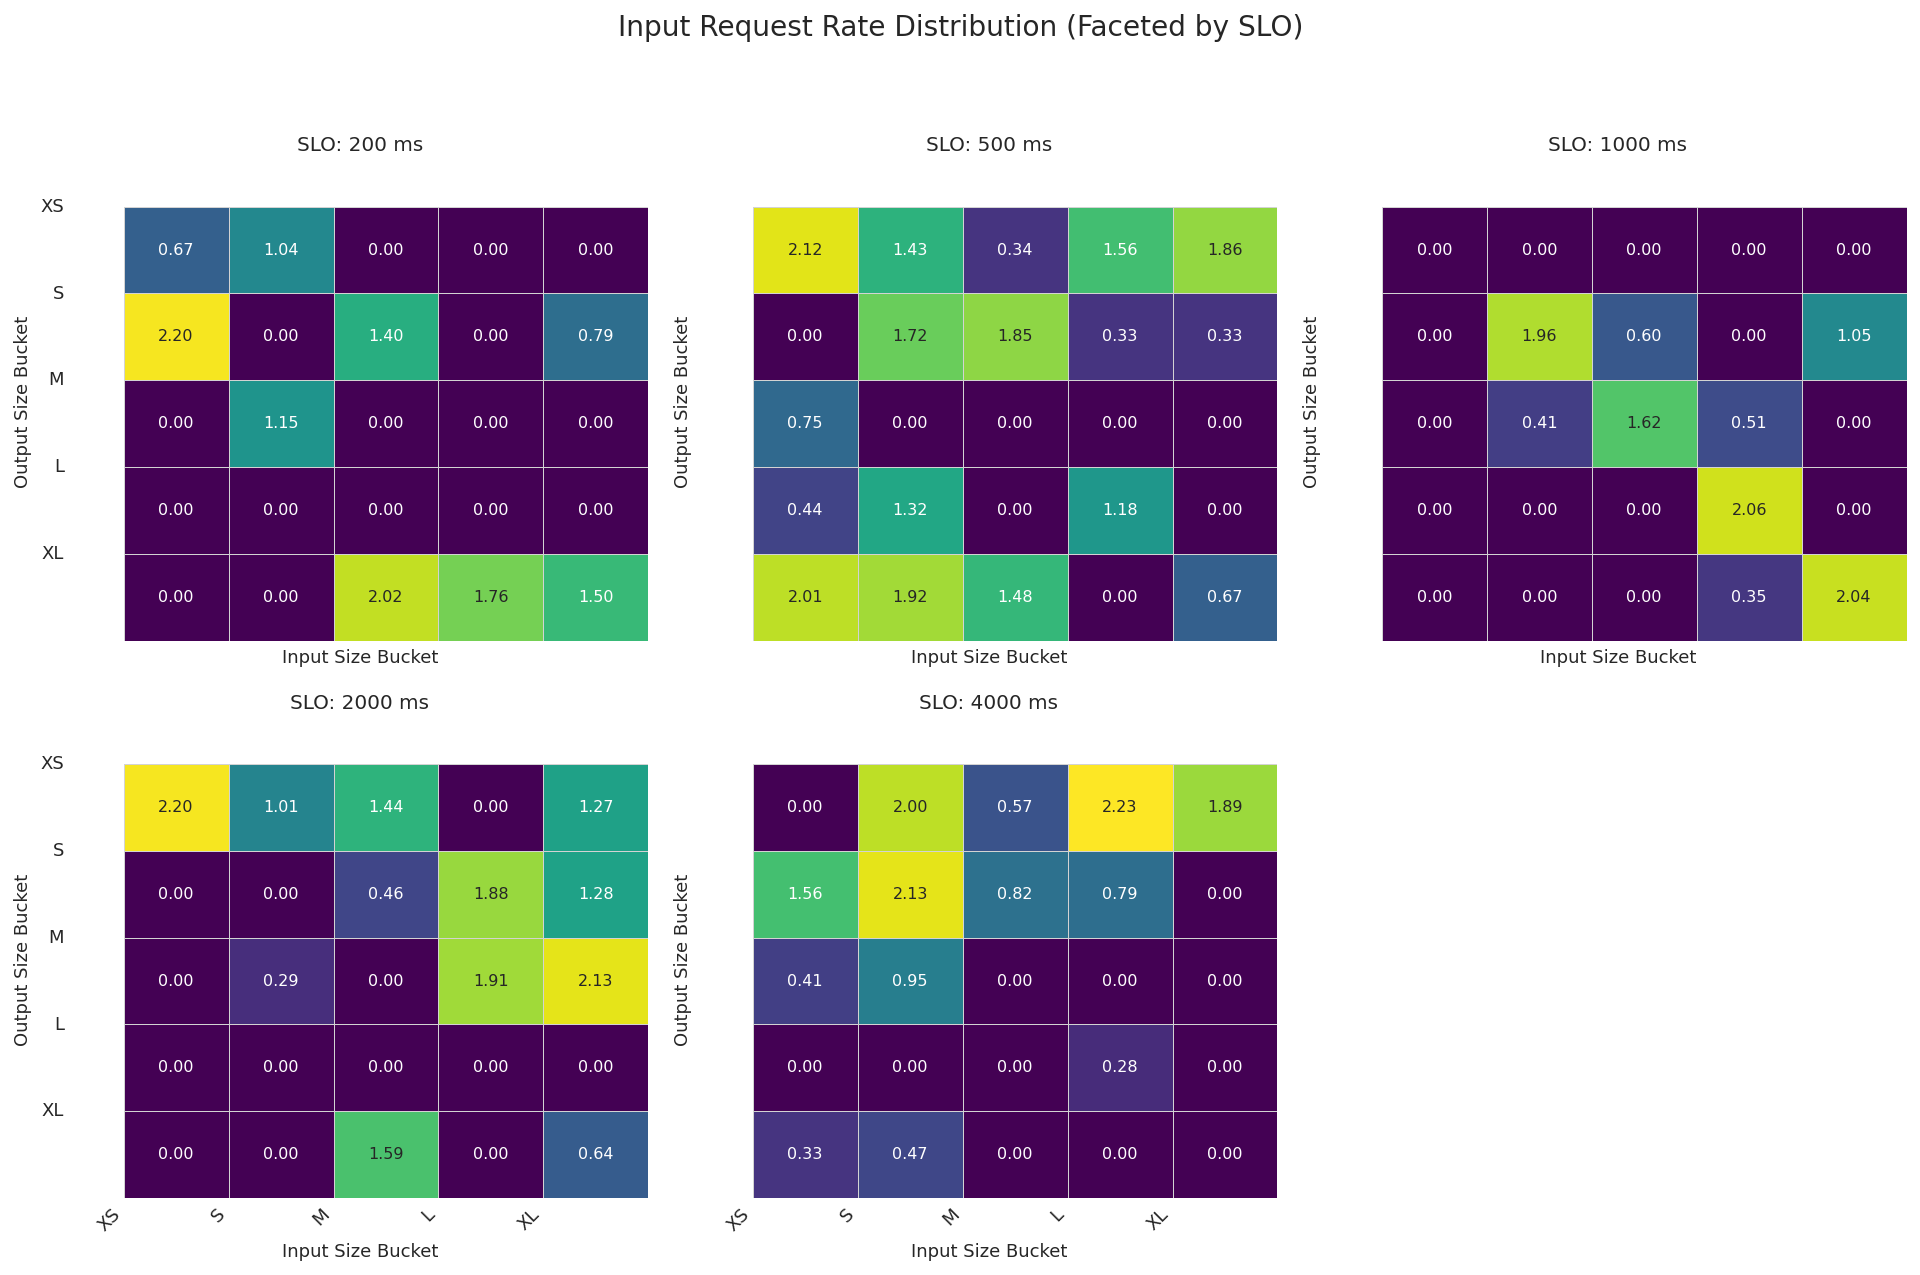

In [ ]:
# Cell 3: Visualize Input Request Rate Distribution

print("--- Preparing Distribution Data for Faceted Visualization ---")

# Needs: distribution_data, request_type_map,
# input_size_map_viz, output_size_map_viz, slo_map_viz,
# input_size_categories_viz, output_size_categories_viz, slo_categories_viz
if ('distribution_data' in locals() and distribution_data and
    'request_type_map' in locals() and request_type_map and
    'input_size_map_viz' in locals() and input_size_map_viz and
    'output_size_map_viz' in locals() and output_size_map_viz and
    'slo_map_viz' in locals() and slo_map_viz and
    'input_size_categories_viz' in locals() and input_size_categories_viz and
    'output_size_categories_viz' in locals() and output_size_categories_viz and
    'slo_categories_viz' in locals() and slo_categories_viz):

    dist_items = []
    max_rate_overall = 0.0
    for req_type_id, rate in distribution_data.items():
        if rate > 1e-6:
            req_type = request_type_map.get(req_type_id)
            if req_type:
                dist_items.append({
                    'req_type_id': req_type_id,
                    'input_size_bucket': req_type.input_size_bucket,
                    'output_size_bucket': req_type.output_size_bucket,
                    'slo_ms': req_type.slo_ms,
                    'rate': rate
                })
                max_rate_overall = max(max_rate_overall, rate)

    dist_df = pd.DataFrame(dist_items)

    if not dist_df.empty:
        # --- Setup Facets based on SLO ---
        num_slo_buckets = len(slo_categories_viz)
        ncols = 3
        nrows = (num_slo_buckets + ncols - 1) // ncols
        print(f"Generating {nrows}x{ncols} faceted plot for {num_slo_buckets} SLO levels...")

        # Create subplots with shared axes
        fig_dist, axes_dist = plt.subplots(
            nrows, ncols,
            figsize=(ncols * 4.5, nrows * 4 + 1.5),
            sharex=True, sharey=True, squeeze=False
        )
        axes_flat = axes_dist.flatten()

        norm = plt.Normalize(vmin=0, vmax=max_rate_overall if max_rate_overall > 0 else 1.0)
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        sm.set_array([])

        # --- Plot each Facet (SLO level) ---
        plot_index = 0
        for i, slo_ms in enumerate(slo_categories_viz):
            if plot_index >= len(axes_flat): break
            ax = axes_flat[plot_index]
            ax.set_title(f"SLO: {slo_ms} ms", fontsize=10)

            facet_df = dist_df[dist_df['slo_ms'] == slo_ms]

            if not facet_df.empty:
                facet_pivot = facet_df.pivot_table(
                    index='output_size_bucket', columns='input_size_bucket', values='rate'
                )
                # Reindex to ensure all categories are present and in correct order
                facet_pivot = facet_pivot.reindex(
                    index=output_size_categories_viz, columns=input_size_categories_viz
                ).fillna(0.0)

                sns.heatmap(
                    facet_pivot, ax=ax, annot=True, fmt=".2f", cmap="viridis",
                    linewidths=0.5, linecolor='lightgray', cbar=False,
                    vmin=0, vmax=max_rate_overall, annot_kws={"size": 8}
                )
            else: # Format empty plot consistently
                ax.set_xlim(-0.5, len(input_size_categories_viz) - 0.5)
                ax.set_ylim(-0.5, len(output_size_categories_viz) - 0.5)
                ax.invert_yaxis() # Match heatmap origin

            # --- Set Ticks, Labels, and Grid on each axis ---
            # Rely on sharex/sharey and tight_layout to hide redundant ones
            ax.set_xticks(np.arange(len(input_size_categories_viz)))
            ax.set_xticklabels(input_size_categories_viz, rotation=45, ha='right', fontsize=9)
            ax.set_xlabel("Input Size Bucket", fontsize=9)

            ax.set_yticks(np.arange(len(output_size_categories_viz)))
            ax.set_yticklabels(output_size_categories_viz, rotation=0, fontsize=9)
            ax.set_ylabel("Output Size Bucket", fontsize=9)

            # Minor ticks for grid (still hidden themselves)
            ax.tick_params(axis='both', which='both', length=0)
            ax.set_xticks(np.arange(len(input_size_categories_viz)+1)-0.5, minor=True)
            ax.set_yticks(np.arange(len(output_size_categories_viz)+1)-0.5, minor=True)
            ax.grid(which='minor', color='white', linestyle=':', linewidth=0.6, alpha=0.5)
            ax.grid(which='major', color='none')

            plot_index += 1

        # --- Hide unused axes ---
        for j in range(plot_index, nrows * ncols):
            axes_flat[j].set_visible(False)


        fig_dist.suptitle('Input Request Rate Distribution (Faceted by SLO)', fontsize=14)

        # tight_layout should handle shared axes labels better now
        try:
            fig_dist.tight_layout(rect=[0, 0.05, 1, 0.95]) # Leave space for suptitle and colorbar
        except ValueError:
             # Fallback if tight_layout fails with certain backends/versions
             print("Warning: tight_layout failed, using subplots_adjust.")
             fig_dist.subplots_adjust(left=0.1, right=0.95, bottom=0.20, top=0.90, wspace=0.15, hspace=0.3)


        plt.show()

    else:
        print("Distribution data frame is empty, skipping faceted plot.")

else:
    print("Skipping Distribution plot as prerequisite data (distribution, maps) is missing.")

## 4. Visualize ILP Solution

This bar chart shows the number of instances provisioned for each Worker Unit type according to the ILP solver's optimal solution. Only worker types with a count greater than zero are shown. The total estimated cost of this provisioning plan is also displayed.

--- Preparing ILP Solution Data for Visualization ---
Generating Solution Bar Chart...


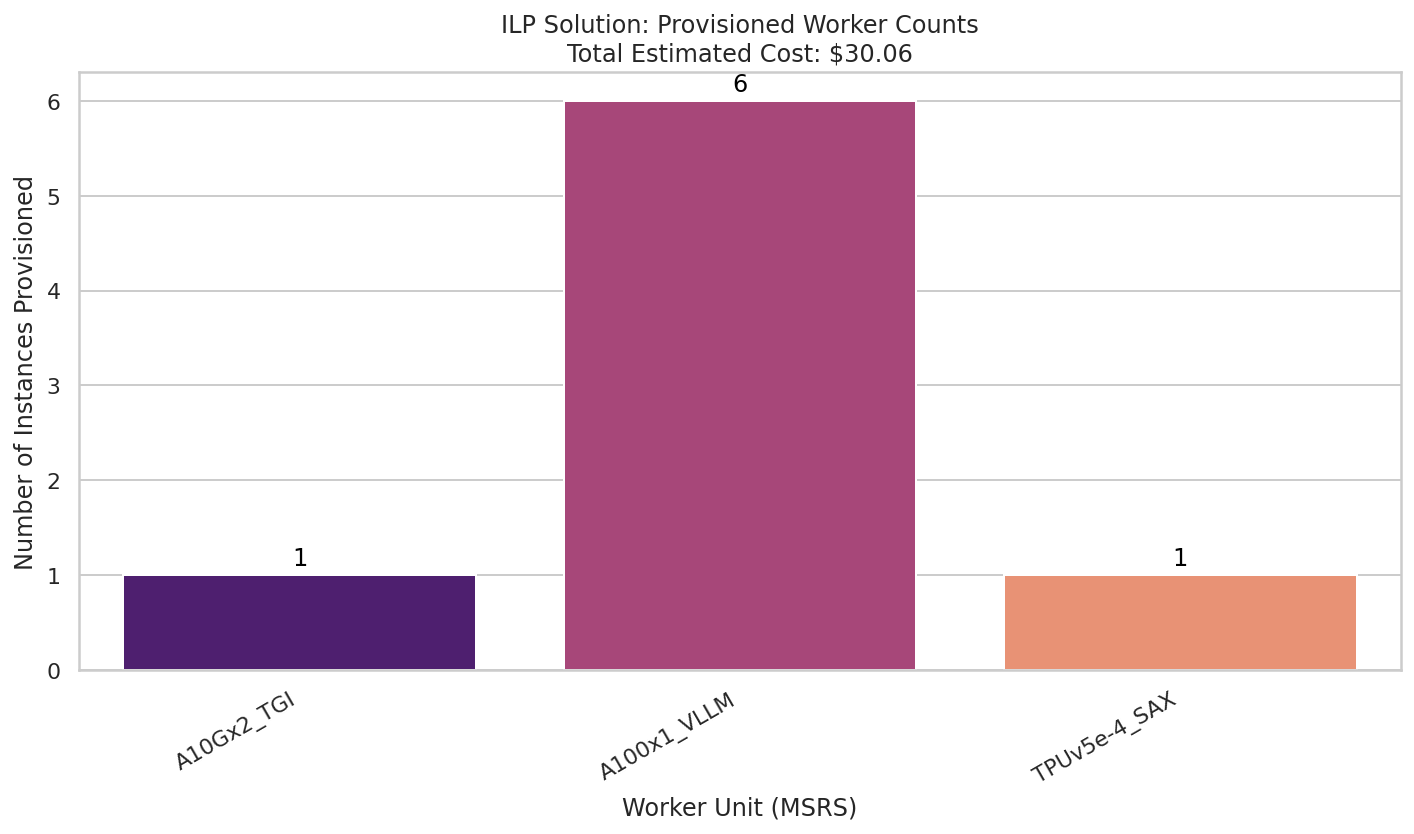

--- Solution Visualization Complete ---


In [5]:
# Cell 4: Visualize ILP Solution

print("--- Preparing ILP Solution Data for Visualization ---")

if optimal_counts: # Check if solver found a solution
    solution_items = []
    total_cost = 0
    for worker_id, count in optimal_counts.items():
        if count > 0:
            worker = worker_unit_map.get(worker_id)
            if worker:
                cost = worker.cost * count
                solution_items.append({
                    'worker_id': worker_id,
                    'count': count,
                    'cost_per_unit': worker.cost,
                    'total_worker_cost': cost
                })
                total_cost += cost
            else:
                print(f"Warning: Worker ID '{worker_id}' from solution not found in map.")

    solution_df = pd.DataFrame(solution_items)

    if not solution_df.empty:
        print("Generating Solution Bar Chart...")
        plt.figure(figsize=(10, 6))
        # Create bar plot
        barplot = sns.barplot(data=solution_df, x='worker_id', y='count', palette='magma')

        # Add counts as labels on top of bars
        for index, row in solution_df.iterrows():
            barplot.text(index, row['count'] + 0.1, int(row['count']), color='black', ha="center")

        plt.title(f'ILP Solution: Provisioned Worker Counts\nTotal Estimated Cost: ${total_cost:.2f}')
        plt.xlabel('Worker Unit (MSRS)')
        plt.ylabel('Number of Instances Provisioned')
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("ILP Solution resulted in zero provisioned units.")
        print(f"Total Estimated Cost: $0.00")

else:
    print("No optimal solution found by the solver. Cannot visualize solution.")

print("--- Solution Visualization Complete ---")


## 5. Visualizing Slice Assignment Details

Before viewing the combined 3D histogram, let's examine the assignment details more closely. We'll look at:

1.  **Full Slice Load Matrix:** A heatmap showing the calculated load (`L_ij`: Slice Rate / Max Throughput) for *every* possible Slice vs. Worker Unit pairing. Assignments made by the ILP solver will be highlighted.
2.  **Top-Down Load Summary:** A 2D grid representing the base of the 3D histogram (Size Bucket vs. SLO), showing the summarized load breakdown per worker type for each category.

In [ ]:
# Cell 5: Data Preparation

print("--- Preparing Data for Step 5 Visualizations ---")

# Initialize outputs of this cell
load_matrix: Dict[Tuple[int, str], float] = {}
slice_loads: Dict[int, float] = {}
total_load_per_worker: Dict[str, float] = {w.id: 0.0 for w in worker_units}
worker_color_map: Dict[str, Any] = {}
default_color = 'grey'
average_rate_portion = 0.01
aggregated_data: Dict[Tuple[int, int, int], Dict[str, Any]] = {}
stack_summary_strings: Dict[Tuple[int, int], str] = {}
max_total_rate = 1.0
slices_by_position_step5 = {}
total_rate_per_position: Dict[Tuple[int, int], float] = {}


# Proceed only if solver results AND position maps are valid
if (optimal_counts is not None and slice_assignments is not None and
    'input_size_map_viz' in locals() and input_size_map_viz and
    'output_size_map_viz' in locals() and output_size_map_viz and
    'slo_map_viz' in locals() and slo_map_viz):

    # --- 1. Calculate Slice Loads AND Full Load Matrix ---
    print("Calculating slice loads and full load matrix...")
    valid_profile_keys_step5 = set(profile_data.keys())
    # First, calculate the full load matrix
    for s in slices:
        for w in worker_units:
            profile_key = (w.id, s.request_type_id)
            load = float('inf') # Default to infinite load
            if profile_key in valid_profile_keys_step5:
                 max_tput = profile_data[profile_key]
                 if max_tput > 0:
                     load = s.rate_portion / max_tput
            load_matrix[(s.id, w.id)] = load # Store load for all pairs

    # Now, calculate slice_loads specifically for assigned slices using the matrix
    for s in slices:
        assigned_worker_id = slice_assignments.get(s.id)
        if assigned_worker_id:
             assigned_load = load_matrix.get((s.id, assigned_worker_id), float('inf')) # Look up pre-calc load
             if isinstance(assigned_load, (int, float)) and not np.isnan(assigned_load) and not np.isinf(assigned_load):
                 slice_loads[s.id] = assigned_load
             else:
                 slice_loads[s.id] = 0.0
                 # print(f"Warning: Slice {s.id} assigned to {assigned_worker_id} has invalid calculated load: {assigned_load}")


    # --- 2. Define Colors, Average Rate ---
    print("Defining color map and average rate portion...")
    # (Color map, default_color, average_rate_portion calculation remains the same)
    default_color = 'grey'
    worker_ids_in_solution = sorted([wid for wid, count in optimal_counts.items() if count > 0])
    if not worker_ids_in_solution: worker_ids_in_solution = sorted(list(worker_unit_map.keys()))
    num_colors_needed = len(worker_ids_in_solution)
    cmap = plt.cm.get_cmap('tab10', max(10, num_colors_needed))
    worker_color_map = { w_id: cmap(i % cmap.N) for i, w_id in enumerate(worker_ids_in_solution) }
    valid_rate_portions = [s.rate_portion for s in slices if s.rate_portion > 0]
    average_rate_portion = np.mean(valid_rate_portions) if valid_rate_portions else 0.01


    # --- 3. Aggregate Data by 3D Category & Calculate Total Load per Worker ---
    print("Aggregating data by (Input, Output, SLO) category...")
    max_total_rate = 0.0 # Reset here before calculating

    # Group slices by position
    # (Logic to create slices_by_position_step5 remains the same)
    for s in slices:
        req_type = request_type_map.get(s.request_type_id)
        if req_type:
            input_pos = input_size_map_viz.get(req_type.input_size_bucket)
            output_pos = output_size_map_viz.get(req_type.output_size_bucket)
            slo_pos = slo_map_viz.get(req_type.slo_ms)
            if input_pos is not None and output_pos is not None and slo_pos is not None:
                pos_key = (input_pos, output_pos, slo_pos)
                slices_by_position_step5.setdefault(pos_key, []).append(s)

    # Calculate summaries per stack and overall totals
    # (Logic to calculate aggregated_data, stack_summary_strings, total_load_per_worker, total_rate_per_position remains the same)
    for position_key, slices_in_group in slices_by_position_step5.items():
        total_rate = sum(s.rate_portion for s in slices_in_group)
        total_rate_per_position[position_key] = total_rate
        max_total_rate = max(max_total_rate, total_rate) # Update max rate here

        stack_summary: Dict[str, Dict[str, Any]] = {}
        for s in slices_in_group:
            assigned_worker_id = slice_assignments.get(s.id)
            if assigned_worker_id:
                load = slice_loads.get(s.id, 0)
                if isinstance(load, (int, float)) and not np.isnan(load) and not np.isinf(load):
                    total_load_per_worker[assigned_worker_id] = total_load_per_worker.get(assigned_worker_id, 0) + load
                    if assigned_worker_id not in stack_summary:
                        stack_summary[assigned_worker_id] = {'total_load': 0.0, 'count': 0}
                    stack_summary[assigned_worker_id]['total_load'] += load
                    stack_summary[assigned_worker_id]['count'] += 1
        if stack_summary:
            summary_items = []
            for wid in sorted(stack_summary.keys()):
                tot_load = stack_summary[wid]['total_load']
                count = stack_summary[wid]['count']
                avg_load = tot_load / count if count > 0 else 0
                summary_items.append(f"{wid}: {tot_load:.2f} ({count} x {avg_load:.2f})")
            stack_summary_strings[position_key] = "\n".join(summary_items)
            aggregated_data[position_key] = {'total_rate': total_rate, 'assignments': stack_summary} # Store aggregated structure

    if max_total_rate <= 0: max_total_rate = 1.0 # Avoid division by zero for opacity


    print("...Data preparation complete.")
    print(f"...Max total rate found across categories: {max_total_rate:.2f}")
    print(f"...Total load calculated for {len(total_load_per_worker)} worker types.")


else:
    print("Skipping Step 5 data preparation as solver failed or position maps missing.")
    # Reset all outputs if skipping
    load_matrix, slice_loads, total_load_per_worker = {}, {}, {w.id: 0.0 for w in worker_units}
    worker_color_map, default_color, average_rate_portion = {}, 'grey', 0.01
    aggregated_data, stack_summary_strings = {}, {}
    max_total_rate = 1.0
    slices_by_position_step5 = {}
    total_rate_per_position = {}

--- Preparing Data for Step 5 Visualizations ---
Calculating slice loads and full load matrix...
Defining color map and average rate portion...
Aggregating data by (Input, Output, SLO) category...
...Data preparation complete.
...Max total rate found across categories: 2.23
...Total load calculated for 9 worker types.


<ipython-input-6-185dfe77a0e5>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(10, num_colors_needed))


--- Generating Figure 5.1: Slice Load Matrix ---


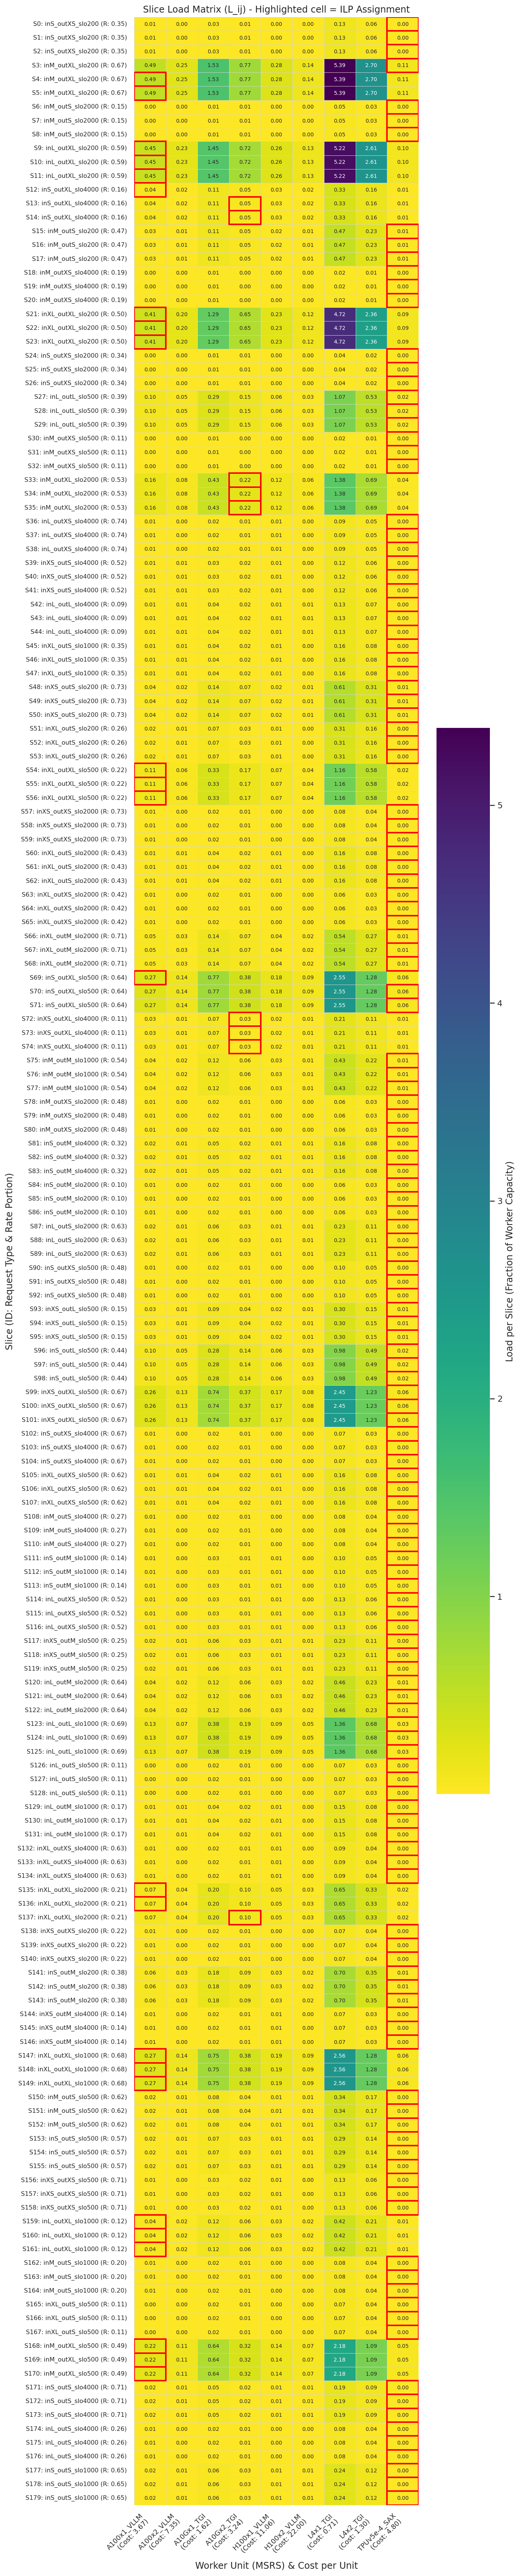

In [ ]:
# Cell 5.1: Slice Load Matrix Heatmap (Corrected)

print("--- Generating Figure 5.1: Slice Load Matrix ---")

if (optimal_counts is not None and
    slice_assignments is not None and
    'load_matrix' in locals() and load_matrix and
    'slices' in locals() and slices and
    'worker_unit_map' in locals() and worker_unit_map and
    'request_type_map' in locals() and request_type_map):

    # Prepare data for heatmap
    slice_map = {s.id: s for s in slices}
    worker_ids_sorted = sorted(list(worker_unit_map.keys()))
    # Filter slice_ids to only those potentially present in load_matrix keys
    slice_ids_present = set(k[0] for k in load_matrix.keys())
    slice_ids_sorted = sorted([s_id for s_id in slice_map.keys() if s_id in slice_ids_present])

    if not slice_ids_sorted:
        print("No valid slice data found in load_matrix. Skipping heatmap.")
    else:
        # Create descriptive labels for slices (Y-axis) using data from slice_map
        descriptive_y_labels = []
        for s_id in slice_ids_sorted:
            s = slice_map[s_id]
            # Ensure request_type_map is used here correctly
            req_type = request_type_map.get(s.request_type_id)
            req_id_str = s.request_type_id if req_type else f"Unknown Type (ID:{s.request_type_id})"
            descriptive_y_labels.append(f"S{s.id}: {req_id_str} (R: {s.rate_portion:.2f})")

        # Build DataFrame directly using load_matrix data and sorted keys
        load_df_data = {
            w_id: [load_matrix.get((s_id, w_id), float('inf')) for s_id in slice_ids_sorted]
            for w_id in worker_ids_sorted
        }
        load_df = pd.DataFrame(load_df_data, index=slice_ids_sorted)
        # Replace inf with NaN for heatmap masking
        load_df = load_df.replace(float('inf'), np.nan)
        # Assign descriptive labels AFTER creating with slice_ids
        load_df.index = descriptive_y_labels

        # Build assignment marker data similarly
        assignment_marker_data = {
            w_id: [(slice_assignments.get(s_id) == w_id) for s_id in slice_ids_sorted]
            for w_id in worker_ids_sorted
        }
        assignment_marker_df = pd.DataFrame(assignment_marker_data, index=descriptive_y_labels)


        if not load_df.empty:
            plt.figure(figsize=(max(10, len(worker_ids_sorted)*1.2), max(10, len(slice_ids_sorted)*0.4))) # Adjusted sizing

            annot_fmt = ".2f"

            # Create heatmap showing the loads
            ax_heatmap = sns.heatmap(
                load_df,
                annot=True,
                fmt=annot_fmt,
                cmap="viridis_r", # Lower load = "better" color
                linewidths=0.5,
                linecolor='lightgray',
                cbar_kws={'label': 'Load per Slice (Fraction of Worker Capacity)'},
                annot_kws={"size": 7},
                mask=load_df.isna() # Mask NaN values (infinite load)
            )

            # Add highlighting for assigned cells using borders
            # Iterate through the descriptive labels (index) and worker ids (columns)
            for r_idx, label in enumerate(load_df.index):
                 for c_idx, w_id in enumerate(load_df.columns):
                     # Use the marker DataFrame with the same labels
                     if assignment_marker_df.loc[label, w_id]:
                         ax_heatmap.add_patch(plt.Rectangle((c_idx, r_idx), 1, 1, fill=False, edgecolor='red', lw=2))

            plt.title('Slice Load Matrix (L_ij) - Highlighted cell = ILP Assignment')
            plt.xlabel('Worker Unit (MSRS) & Cost per Unit')
            plt.ylabel('Slice (ID: Request Type & Rate Portion)')

            # Create X-tick labels with Cost (using worker_unit_map)
            cost_labels = []
            for w_id in worker_ids_sorted:
                worker_obj = worker_unit_map.get(w_id)
                cost = worker_obj.cost if worker_obj else 'N/A'
                cost_str = f"{cost:.2f}" if isinstance(cost, (int, float)) else str(cost)
                cost_labels.append(f"{w_id}\n(Cost: {cost_str})")

            # Get current ticks positions and apply new labels
            tick_positions = np.arange(len(worker_ids_sorted)) + 0.5
            ax_heatmap.set_xticks(tick_positions)
            ax_heatmap.set_xticklabels(cost_labels, rotation=45, ha='right', fontsize=9)

            plt.yticks(rotation=0, fontsize=8) # Use descriptive labels already set as index
            plt.subplots_adjust(left=0.3, bottom=0.25) # Adjust space for labels
            plt.show()
        else:
            print("Load DataFrame is empty, cannot generate heatmap.")

else:
    print("Skipping Slice Load Matrix plot as prerequisite data is missing from previous cells.")

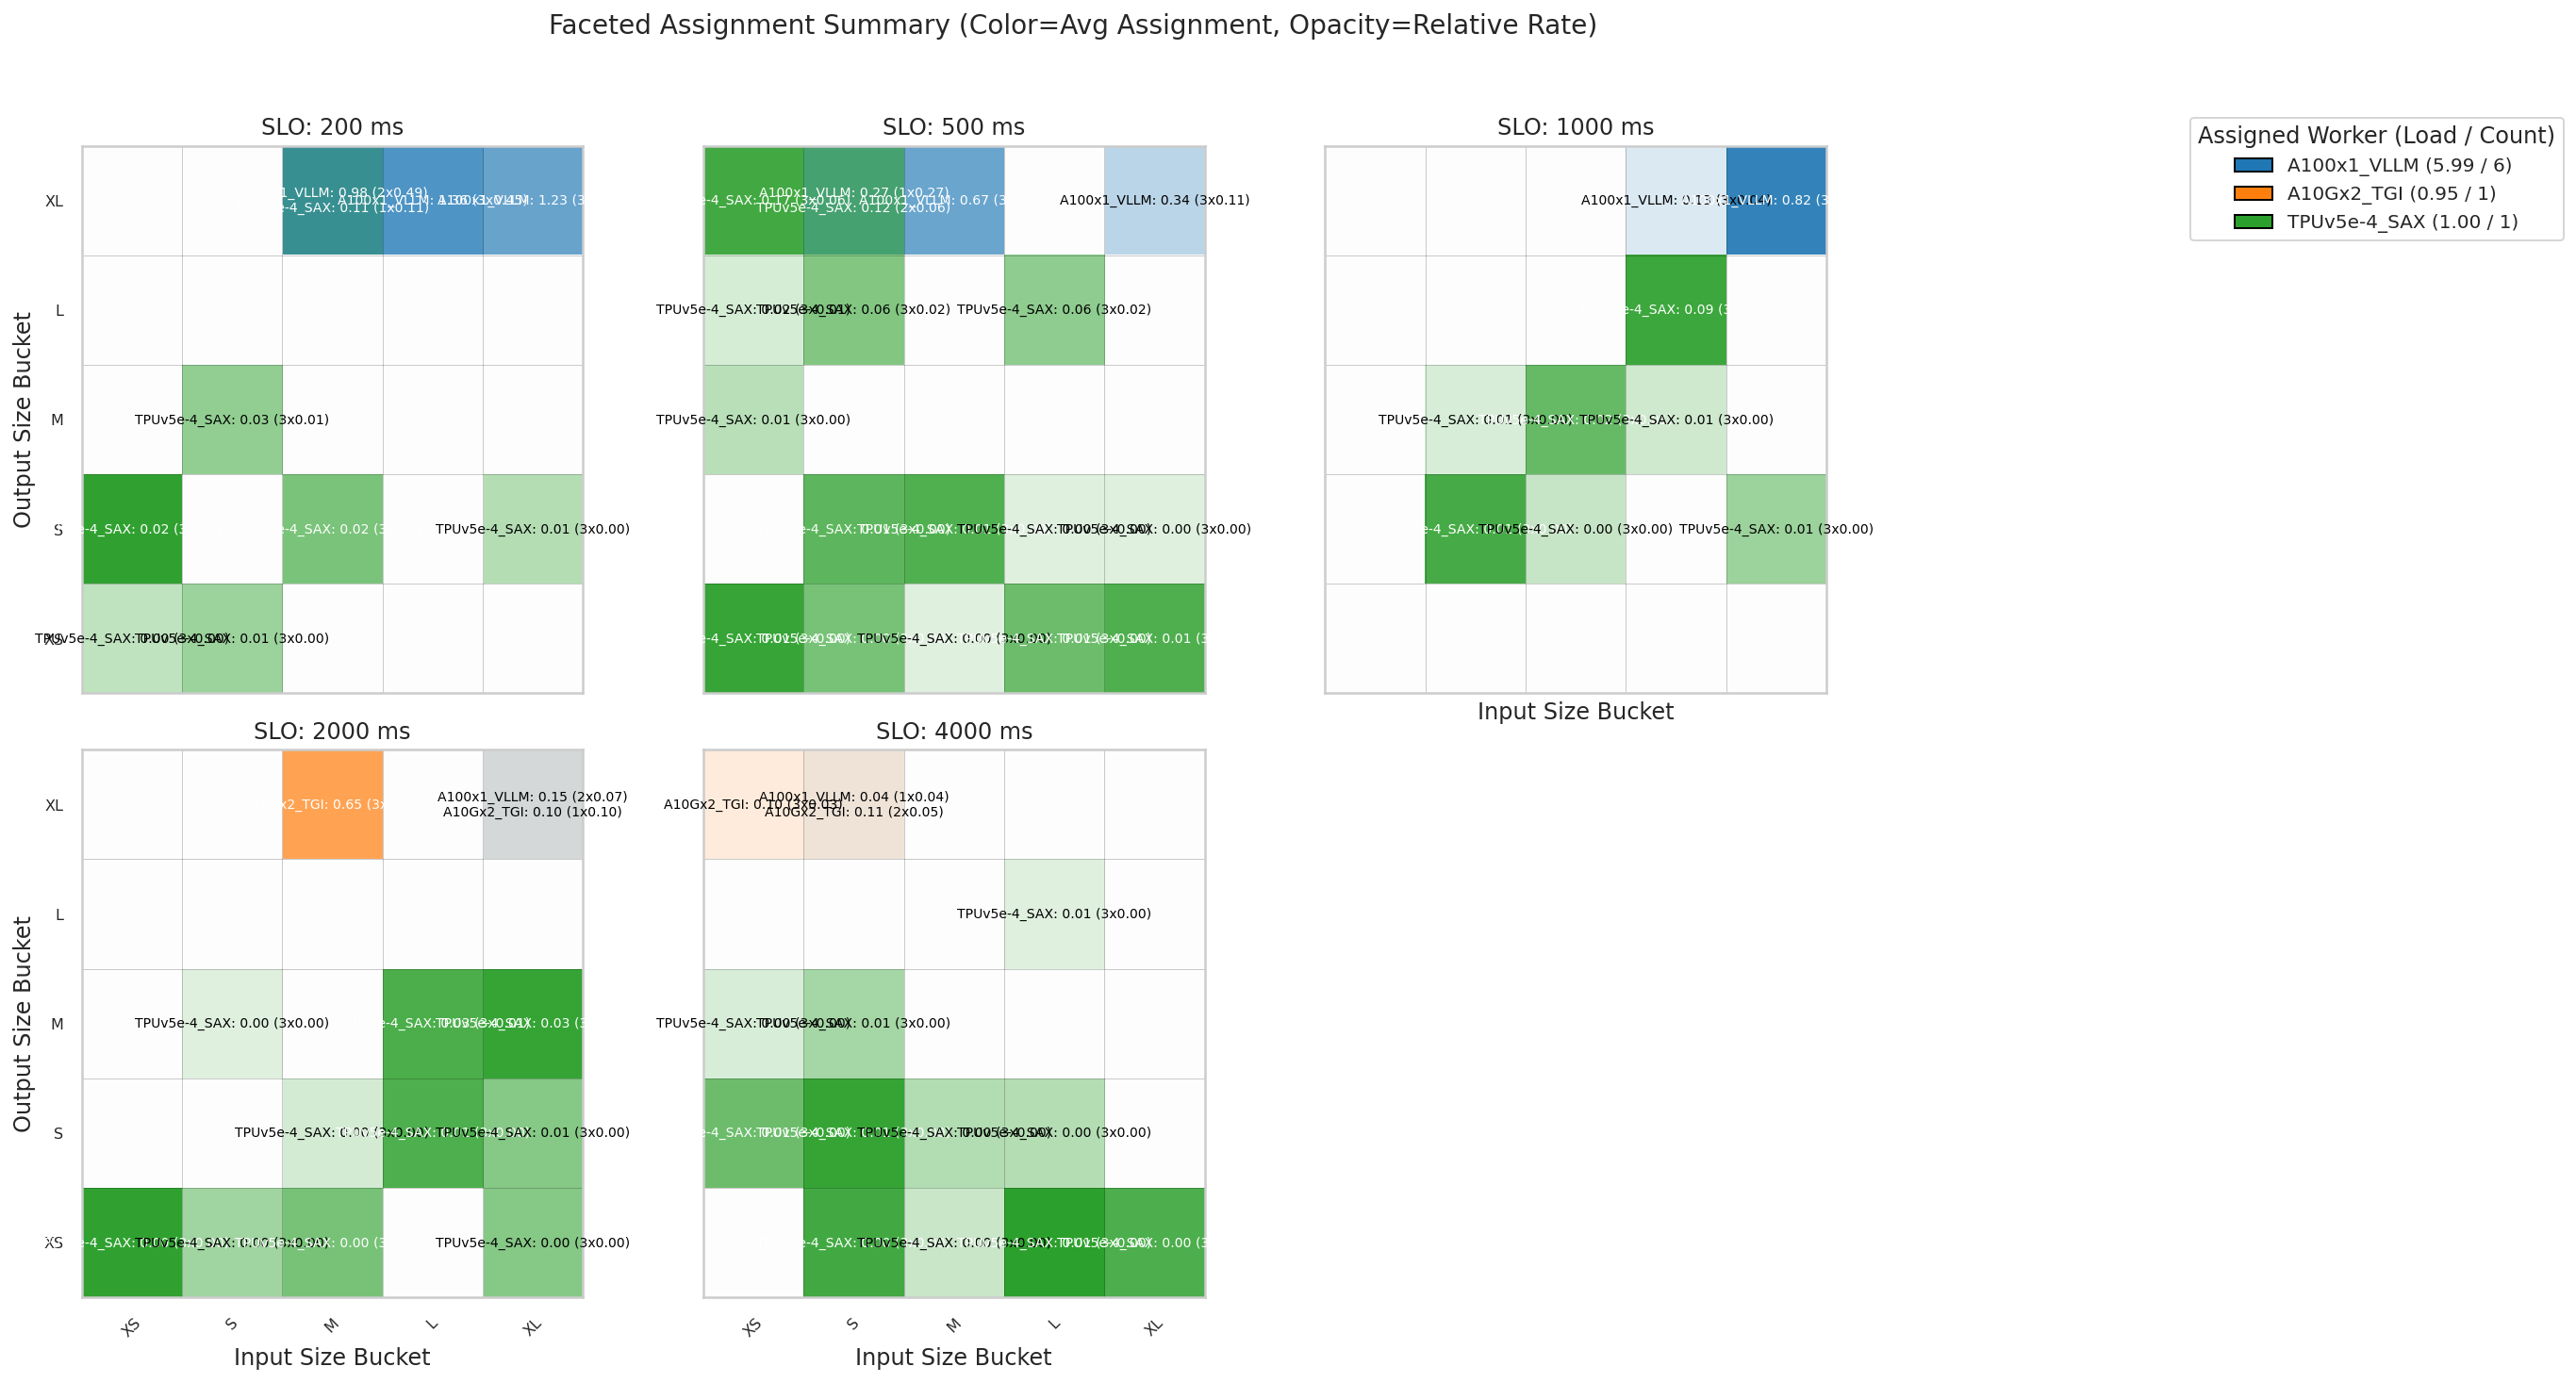


--- Faceted Assignment Visualization Complete ---


In [8]:
# Cell 5.2: Faceted Assignment Visualization

print("--- Generating Faceted Assignment Visualization ---")

# Function to determine text color based on background brightness
def get_text_color_facet(bg_color_rgba):
    r, g, b, a = bg_color_rgba
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    # Consider alpha - if background is quite transparent, use black
    return 'black' if luminance > 0.6 or a < 0.6 else 'white'

# --- Check if necessary data exists ---
if ('aggregated_data' in locals() and aggregated_data and
    'max_total_rate' in locals() and max_total_rate > 0 and
    'worker_color_map' in locals() and worker_color_map and
    'input_size_map_viz' in locals() and input_size_map_viz and
    'output_size_map_viz' in locals() and output_size_map_viz and
    'slo_map_viz' in locals() and slo_map_viz):

    # --- Determine Facet Layout ---
    # Facet by SLO
    slo_categories_sorted = sorted(slo_map_viz.keys())
    num_slo_buckets = len(slo_categories_sorted)
    # Arrange facets (e.g., in a row, or wrap columns)
    ncols = min(num_slo_buckets, 3) # Max 3 columns wide
    nrows = (num_slo_buckets + ncols - 1) // ncols
    fig_facet, axes_facet = plt.subplots(nrows, ncols, figsize=(ncols * 5 + 1, nrows * 5), squeeze=False, sharex=True, sharey=True)
    axes_flat = axes_facet.flatten()

    num_input_cats = len(input_size_map_viz)
    num_output_cats = len(output_size_map_viz)

    # --- Plot each Facet ---
    print(f"Generating {num_slo_buckets} facets (SLO Buckets)...")
    for i, slo_ms in enumerate(slo_categories_sorted):
        slo_pos = slo_map_viz[slo_ms]
        ax = axes_flat[i]
        ax.set_title(f"SLO: {slo_ms} ms")

        # Create RGBA grid for this facet
        rgba_grid_facet = np.zeros((num_output_cats, num_input_cats, 4))
        rgba_grid_facet[:, :, :3] = 0.95 # Light grey background for empty cells
        rgba_grid_facet[:, :, 3] = 0.1  # Very low alpha for empty cells

        summary_strings_facet: Dict[Tuple[int, int], str] = {}

        # Calculate colors and opacities for cells in this facet
        for input_cat, input_pos in input_size_map_viz.items():
             for output_cat, output_pos in output_size_map_viz.items():
                 pos_key = (input_pos, output_pos, slo_pos)
                 combo_data = aggregated_data.get(pos_key)

                 if combo_data and combo_data['total_rate'] > 0:
                     assignments = combo_data['assignments']
                     total_slices_in_combo = sum(d['count'] for d in assignments.values())

                     if total_slices_in_combo > 0:
                         avg_r, avg_g, avg_b = 0.0, 0.0, 0.0
                         summary_items = []
                         for worker_id, data in sorted(assignments.items()):
                             weight = data['count'] / total_slices_in_combo
                             worker_color = worker_color_map.get(worker_id, (0.5, 0.5, 0.5, 1.0))
                             if len(worker_color) >= 3:
                                 avg_r += weight * worker_color[0]
                                 avg_g += weight * worker_color[1]
                                 avg_b += weight * worker_color[2]
                             # Format summary string part
                             tot_load = data['total_load']
                             count = data['count']
                             avg_load = tot_load / count if count > 0 else 0
                             summary_items.append(f"{worker_id}: {tot_load:.2f} ({count}x{avg_load:.2f})")

                         opacity = np.clip(combo_data['total_rate'] / max_total_rate, 0.15, 1.0)
                         # Store color in grid (output=row, input=col)
                         rgba_grid_facet[output_pos, input_pos] = [avg_r, avg_g, avg_b, opacity]
                         # Store formatted summary string for this cell
                         summary_strings_facet[(input_pos, output_pos)] = "\n".join(summary_items)


        # --- Plotting for this Facet ---
        x_boundaries = np.arange(num_input_cats + 1) - 0.5
        y_boundaries = np.arange(num_output_cats + 1) - 0.5
        ax.imshow(rgba_grid_facet, interpolation='nearest', origin='lower', aspect='auto',
                   extent=[x_boundaries[0], x_boundaries[-1], y_boundaries[0], y_boundaries[-1]])

        # Add summary text
        for (input_pos, output_pos), summary_str in summary_strings_facet.items():
             bg_color = rgba_grid_facet[output_pos, input_pos]
             text_color = get_text_color_facet(bg_color)
             ax.text(input_pos, output_pos, summary_str, ha='center', va='center', fontsize=7, color=text_color, wrap=True)

        # --- Customize Axes for this Facet ---
        ax.set_xticks(list(input_size_map_viz.values()))
        ax.set_yticks(list(output_size_map_viz.values()))
        ax.set_xticklabels(list(input_size_map_viz.keys()))
        ax.set_yticklabels(list(output_size_map_viz.keys()))
        ax.tick_params(axis='x', labelrotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

        # Add grid lines
        ax.set_xticks(x_boundaries, minor=True)
        ax.set_yticks(y_boundaries, minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5, alpha=0.2)
        ax.grid(which='major', color='none')

        if i % ncols == 0: # Only add Y label to leftmost column
            ax.set_ylabel('Output Size Bucket')
        if i >= (num_slo_buckets - ncols): # Only add X label to bottom row
            ax.set_xlabel('Input Size Bucket')


    # --- Hide unused axes if layout isn't square ---
    for j in range(i + 1, nrows * ncols):
        axes_flat[j].set_visible(False)

    # --- Create Shared Legend ---
    legend_elements_final = []
    worker_ids_for_legend_final = sorted(worker_color_map.keys())
    for worker_id in worker_ids_for_legend_final:
         total_load = total_load_per_worker.get(worker_id, 0)
         count = optimal_counts.get(worker_id, 0)
         label_ratio = f"({total_load:.2f} / {count})" if count > 0 else "(Load / 0)"
         label = f"{worker_id} {label_ratio}"
         color = worker_color_map.get(worker_id, default_color)
         legend_elements_final.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))

    if legend_elements_final:
        # Place legend outside the subplots
        fig_facet.legend(handles=legend_elements_final, title="Assigned Worker (Load / Count)",
                         bbox_to_anchor=(1.01, 0.95), loc='upper left', fontsize='small')

    fig_facet.suptitle('Faceted Assignment Summary (Color=Avg Assignment, Opacity=Relative Rate)', fontsize=14, y=1.02)
    fig_facet.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust right margin for legend
    plt.show()

else:
    print("Skipping Faceted Visualization as prerequisite data is missing.")

print("\n--- Faceted Assignment Visualization Complete ---")

## 6. Faceted 3D Slice Assignment Histograms

This visualization provides another view of the assignment results, splitting the workload into separate 3D histograms based on SLO level. Within each plot:
* X-axis: Input Size Bucket
* Y-axis: Output Size Bucket
* Z-axis: Request Rate (Requests per Second)
* Bar segments are stacked, representing individual slices.
* Segment color indicates the assigned Worker Unit type.
* Text above each stack summarizes the load breakdown for that Input/Output/SLO combination.

*(Note: Rendering multiple complex 3D plots might be slow in some notebook environments.)*

--- Generating Step 6: Faceted 3D Assignment Histograms (Legend Repositioned) ---
Generating 2x3 faceted 3D plot for 5 SLO levels...
Placing legend in subplot index 5.


<ipython-input-9-ddb8db822e98>:129: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig_3d_facet.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect top for suptitle


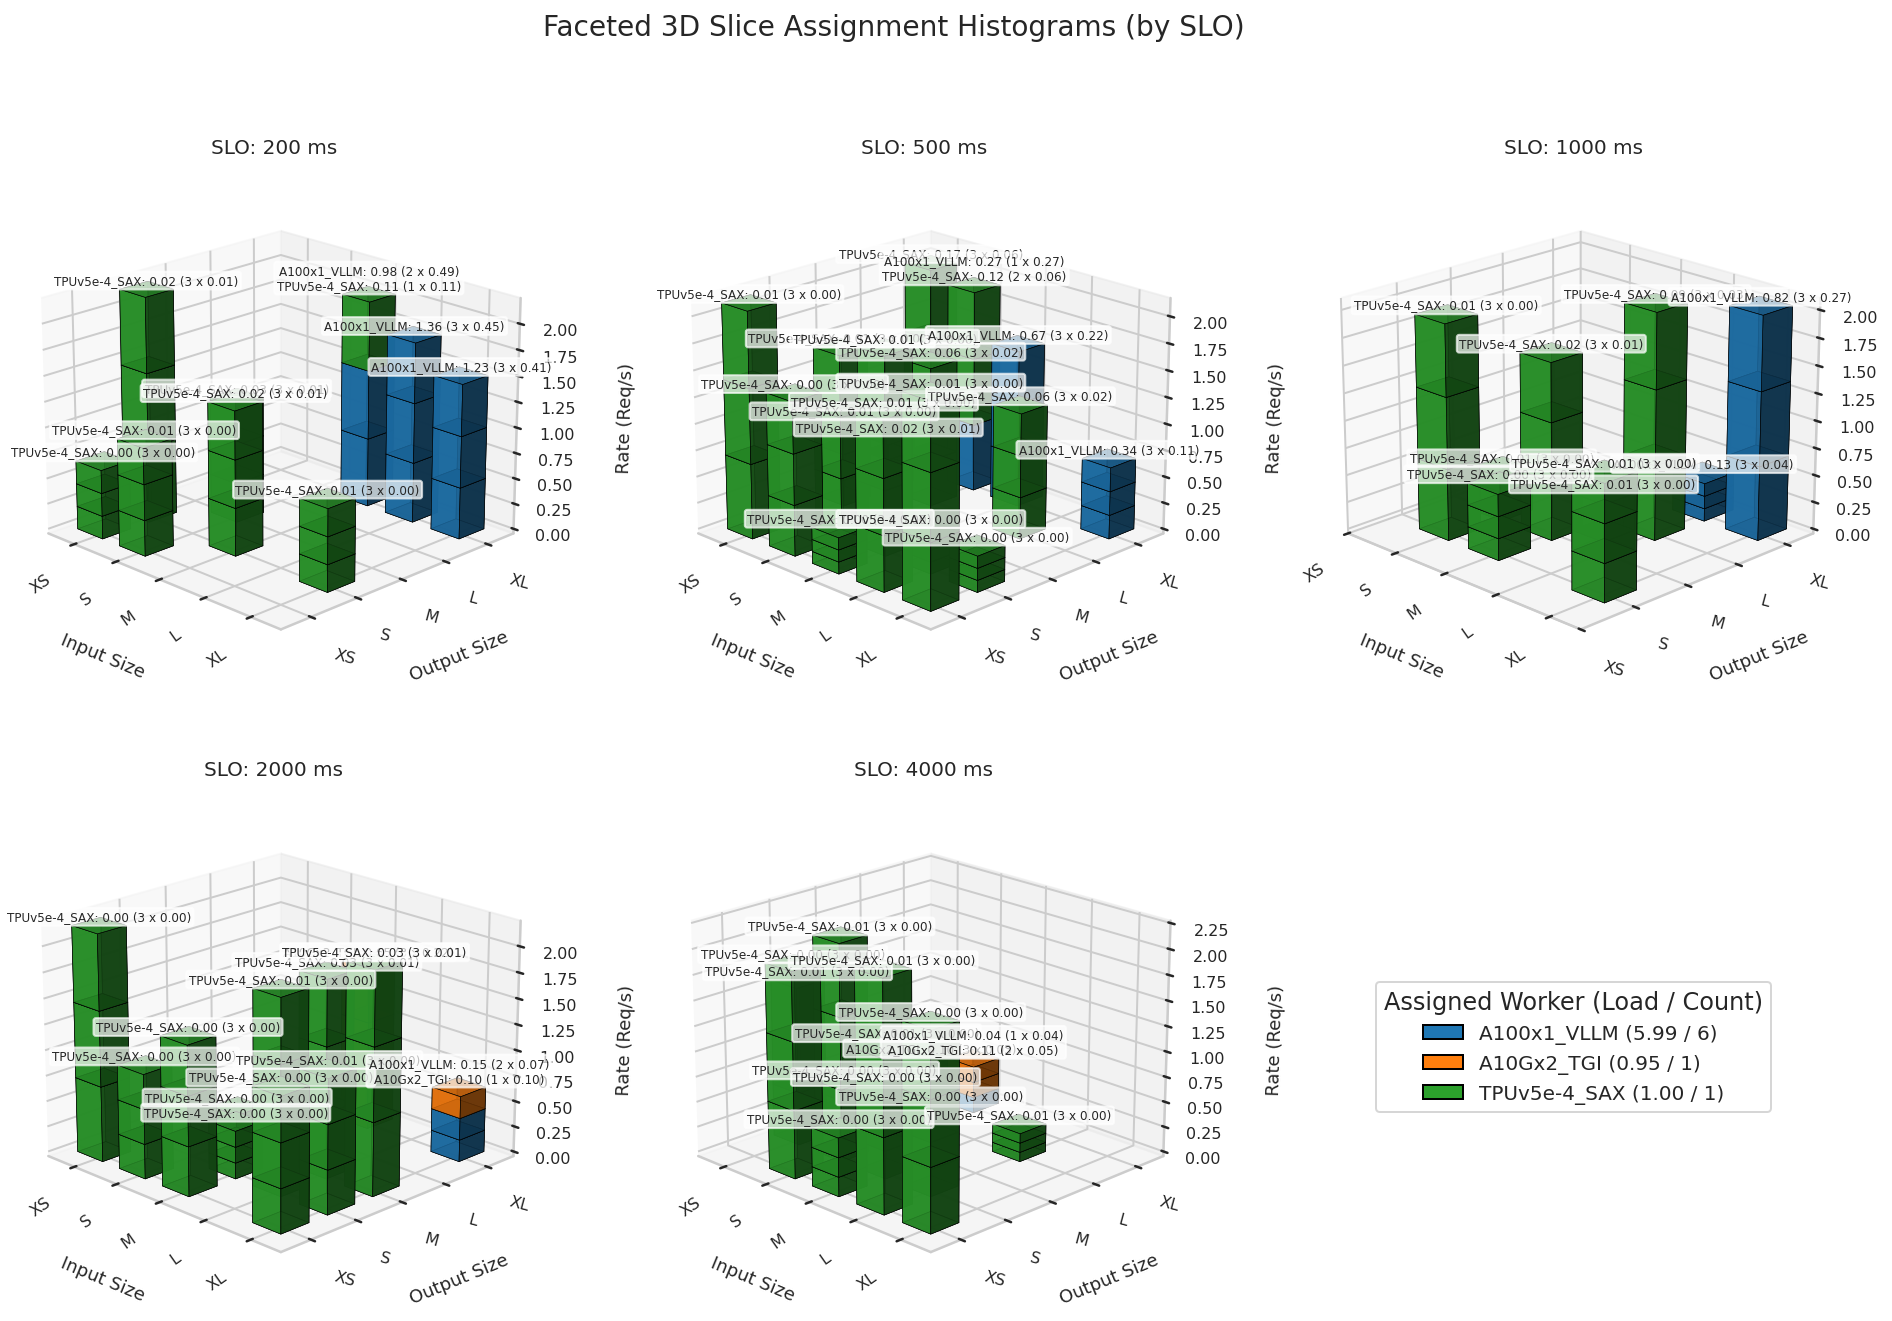

In [ ]:
# Cell: Step 6 - Faceted 3D Slice Assignment Histograms

print("--- Generating Step 6: Faceted 3D Assignment Histograms (Legend Repositioned) ---")

# Check if necessary data exists from Step 5 Prep cell
if ('aggregated_data' in locals() and aggregated_data and
    'slices_by_position_step5' in locals() and slices_by_position_step5 and
    'stack_summary_strings' in locals() and
    'total_load_per_worker' in locals() and
    'worker_color_map' in locals() and worker_color_map and
    'optimal_counts' in locals() and optimal_counts is not None and
    'input_size_map_viz' in locals() and input_size_map_viz and
    'output_size_map_viz' in locals() and output_size_map_viz and
    'slo_map_viz' in locals() and slo_map_viz and
    'input_size_categories_viz' in locals() and input_size_categories_viz and
    'output_size_categories_viz' in locals() and output_size_categories_viz and
    'slo_categories_viz' in locals() and slo_categories_viz and
    'average_rate_portion' in locals() and
    'default_color' in locals()):

    # --- Setup Facets based on SLO ---
    num_slo_buckets = len(slo_categories_viz)
    ncols = 3
    nrows = (num_slo_buckets + ncols - 1) // ncols
    print(f"Generating {nrows}x{ncols} faceted 3D plot for {num_slo_buckets} SLO levels...")

    fig_3d_facet, axes_3d_facet = plt.subplots(
        nrows, ncols,
        figsize=(ncols * 5.5, nrows * 5 + 0.5),
        squeeze=False,
        subplot_kw={'projection': '3d'}
    )
    axes_flat_3d = axes_3d_facet.flatten()

    # --- Plot each Facet (SLO level) ---
    plot_index = 0
    for i, slo_ms in enumerate(slo_categories_viz):
        if plot_index >= len(axes_flat_3d): break
        ax = axes_flat_3d[plot_index]
        ax.set_title(f"SLO: {slo_ms} ms", fontsize=10)
        slo_pos = slo_map_viz[slo_ms]

        current_stack_heights_facet = {}

        # Iterate through Input and Output size positions
        for input_cat, input_pos in input_size_map_viz.items():
             for output_cat, output_pos in output_size_map_viz.items():
                 pos_key = (input_pos, output_pos, slo_pos)
                 slices_in_group = slices_by_position_step5.get(pos_key, [])

                 if slices_in_group:
                     dx, dy = 0.6, 0.6
                     xpos, ypos = input_pos - dx / 2, output_pos - dy / 2
                     current_z = 0 # Reset for each bar

                     slices_in_group.sort(key=lambda s: slice_assignments.get(s.id, ''))

                     for s in slices_in_group:
                         assigned_worker_id = slice_assignments.get(s.id)
                         if not assigned_worker_id: continue
                         color = worker_color_map.get(assigned_worker_id, default_color)
                         zpos, dz = current_z, s.rate_portion
                         ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=color, shade=True, edgecolor='black', linewidth=0.3, alpha=0.85)
                         current_z += dz

                     summary_string = stack_summary_strings.get(pos_key)
                     if summary_string:
                         summary_text_x = xpos + dx / 2
                         summary_text_y = ypos + dy / 2
                         summary_text_z = current_z + 0.05 * average_rate_portion
                         ax.text(summary_text_x, summary_text_y, summary_text_z, summary_string,
                                 ha='center', va='bottom', fontsize=6, zorder=100, # Change fontsize as needed
                                 bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

        # Customize Axes for this Facet
        ax.set_xticks(list(input_size_map_viz.values()))
        ax.set_xticklabels(list(input_size_map_viz.keys()), rotation=35, ha='right', fontsize=8)
        ax.set_xlabel('Input Size', fontsize=9, labelpad=10)

        ax.set_yticks(list(output_size_map_viz.values()))
        ax.set_yticklabels(list(output_size_map_viz.keys()), rotation=-15, ha='left', fontsize=8)
        ax.set_ylabel('Output Size', fontsize=9, labelpad=10)

        ax.set_zlabel('Rate (Req/s)', fontsize=9, labelpad=10)
        ax.tick_params(axis='z', labelsize=8)
        ax.view_init(elev=20., azim=-45) # Set view angle

        plot_index += 1

    # --- Handle Legend in Unused Axes ---
    legend_axis_index = -1 # Default if grid is full
    if plot_index < nrows * ncols:
         legend_axis_index = plot_index # Use the next available axis index

    # Hide remaining truly unused axes (if any beyond the legend axis)
    for j in range(plot_index + 1, nrows * ncols):
        axes_flat_3d[j].set_visible(False)

    # --- Create Legend Elements ---
    legend_elements_step6 = []
    worker_ids_for_legend_step6 = sorted(worker_color_map.keys())
    for worker_id in worker_ids_for_legend_step6:
         total_load = total_load_per_worker.get(worker_id, 0)
         count = optimal_counts.get(worker_id, 0)
         label_ratio = f"({total_load:.2f} / {count})" if count > 0 else "(Load / 0)"
         label = f"{worker_id} {label_ratio}"
         color = worker_color_map.get(worker_id, default_color)
         legend_elements_step6.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))

    # --- Place Legend in the Designated Axis ---
    if legend_axis_index != -1 and legend_elements_step6:
        ax_legend = axes_flat_3d[legend_axis_index]
        # Turn off the 3D axis appearance for the legend subplot
        ax_legend.set_axis_off()
        # Place legend in the center of this axis
        ax_legend.legend(handles=legend_elements_step6, title="Assigned Worker (Load / Count)",
                         loc='center', fontsize='small')
        print(f"Placing legend in subplot index {legend_axis_index}.")
    elif legend_elements_step6:
         # Fallback if grid was full - place outside figure (might overlap again)
         print("Warning: Subplot grid is full, placing legend outside figure.")
         fig_3d_facet.legend(handles=legend_elements_step6, title="Assigned Worker (Load / Count)",
                            bbox_to_anchor=(0.99, 0.95), loc='upper left', fontsize='small')


    fig_3d_facet.suptitle('Faceted 3D Slice Assignment Histograms (by SLO)', fontsize=14)
    # Use tight_layout - should work better now legend is inside an axis boundary
    try:
        fig_3d_facet.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect top for suptitle
    except ValueError:
        print("Warning: tight_layout failed, using default layout.")


    plt.show()

else:
    print("Skipping Faceted 3D Plot as prerequisite data from Step 5 Prep is missing.")